# Outlier Detection with Isolation Forest

This notebook will show some feature expansion in order to detect anomalies and outlier behaviours.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

np.random.seed(1234)

%matplotlib inline

### Exp * log transformation

I'll try to use and exponential * log function. This is shown in the figure below.

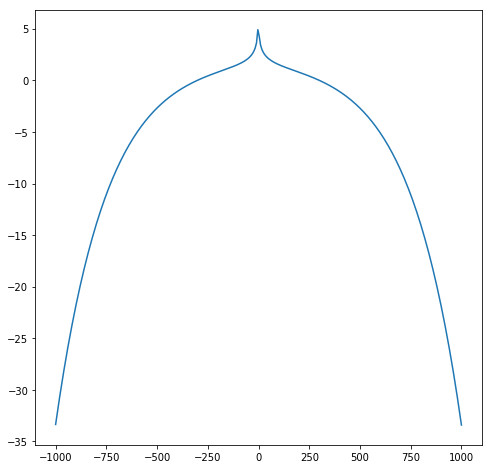

In [12]:
plt.figure(figsize=(8,8))

limit = 300
value = np.linspace(-1000,1000,300)

plt.plot(value, np.exp(np.absolute(value/(limit+1))) * np.log(np.absolute(limit/(value+1))))
plt.show()

Cool, we can see that there are 2 long falls in the plot. This will be used to model out outlier behaviour. One of the applications for this approach is credit card money laundry, where some client is using his credit card way over his limit.

Let's create some synthetic data first.

In [3]:
a = np.random.randint(15000, size=(50000,5))
months_list = ['m0','m1','m2','m3','m4']
df = pd.DataFrame(a, columns = months_list)

In [4]:
df

,m0,m1,m2,m3,m4
0,11055,8915,1318,7221,11468
1,7540,664,6137,6833,8471
2,9449,7322,8222,1182,7916
3,8060,7962,13686,10682,10360
4,14192,7644,11589,11600,9161
5,2431,246,2558,3503,5682
6,3824,5883,5196,14629,14114
7,12198,1530,13507,10983,7307
8,6784,4841,12107,10576,3
9,1282,1299,11148,14273,6603


Now let's apply the exp*log transformation

In [5]:
for col in df:
    value = df[col]
    df[col+'_feat'] = np.exp(np.absolute(value/(limit+1))) * np.log(np.absolute(limit/(value+1)))

/usr/local/lib/python3.5/dist-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


In [6]:
df.head()

,m0,m1,m2,m3,m4,m0_feat,m1_feat,m2_feat,m3_feat,m4_feat
0,11055,8915,1318,7221,11468,-3.219013e+16,-2.473665e+13,-1.180787e+02,-8.342900e+10,-1.282356e+17
1,7540,664,6137,6833,8471,-2.440303e+11,-7.227041e+00,-2.160175e+09,-2.258865e+10,-5.573528e+12
2,9449,7322,8222,1182,7916,-1.483206e+14,-1.172022e+11,-2.415282e+12,-6.963025e+01,-8.638852e+11
3,8060,7962,13686,10682,10360,-1.401555e+12,-1.008311e+12,-2.132077e+20,-9.234041e+15,-3.140952e+15
4,14192,7644,11589,11600,9161,-1.156077e+21,-3.462103e+11,-1.922389e+17,-1.994459e+17,-5.646121e+13


## Isolation Forest

I'll use the Isolation Forest algorithm. It works like the following:
- It will create a forest of Extra Trees;
- Each tree is gonna make splits on the features randomly;
- For inliers data points, the forest is gonna make several splits in order to isolate it.
- For outliers data points, few splits are needed.

In [7]:
features = ['m0_feat','m1_feat','m2_feat','m3_feat','m4_feat']

isofor = IsolationForest(contamination = 0.01).fit(df[features])

preds = isofor.predict(df[features])
scores = isofor.decision_function(df[features])

Creating scores and predictions. Predictions = -1 are considered to be outliers.

In [8]:
df['preds'] = preds
df['scores'] = scores

In [9]:
df[df.preds == -1].sort_values('scores')

,m0,m1,m2,m3,m4,m0_feat,m1_feat,m2_feat,m3_feat,m4_feat,preds,scores
13668,14228,14847,14877,14829,2893,-1.303809e+21,-1.030616e+22,-1.139218e+22,-9.704897e+21,-3.384620e+04,-1,-0.237255
42025,12961,14982,14964,13380,3447,-1.890225e+19,-1.617657e+22,-1.523288e+22,-7.668605e+19,-2.297046e+05,-1,-0.237072
47734,3553,14839,14953,14913,9316,-3.307219e+05,-1.003447e+22,-1.468348e+22,-1.284748e+22,-9.495458e+13,-1,-0.233955
23054,11368,14966,14976,8994,8063,-9.176555e+16,-1.533495e+22,-1.585569e+22,-3.224431e+13,-1.415754e+12,-1,-0.228722
16458,14927,14997,14391,12651,8809,-1.346238e+22,-1.700749e+22,-2.247381e+21,-6.705528e+18,-1.733268e+13,-1,-0.226490
22020,13896,14981,11593,14056,14787,-4.300576e+20,-1.612265e+22,-1.948290e+17,-7.339645e+20,-8.434820e+21,-1,-0.224151
35789,3216,14677,14785,14919,14472,-1.036004e+05,-5.841587e+21,-8.378669e+21,-1.310749e+22,-2.945614e+21,-1,-0.221366
41837,14148,14925,14896,12675,3476,-9.980493e+20,-1.337277e+22,-1.213844e+22,-7.265759e+18,-2.538044e+05,-1,-0.220603
6105,14903,14986,9292,1024,14617,-1.242553e+22,-1.639410e+22,-8.761161e+13,-3.688931e+01,-4.780827e+21,-1,-0.220557
20677,14956,14757,10797,14860,11885,-1.483132e+22,-7.630699e+21,-1.357119e+16,-1.076345e+22,-5.174978e+17,-1,-0.218980


In [10]:
df[df.preds == 1].sort_values('scores', ascending=False)

,m0,m1,m2,m3,m4,m0_feat,m1_feat,m2_feat,m3_feat,m4_feat,preds,scores
0,11055,8915,1318,7221,11468,-3.219013e+16,-2.473665e+13,-1.180787e+02,-8.342900e+10,-1.282356e+17,1,0.200893
25878,4283,6423,7326,3474,9428,-4.021371e+06,-5.670801e+09,-1.187904e+11,-2.520643e+05,-1.382362e+14,1,0.200893
25873,1575,10856,3101,1892,5675,-3.106573e+02,-1.653504e+16,-6.961770e+04,-9.889461e+02,-4.534089e+08,1,0.200893
25872,6645,6256,9033,4704,1631,-1.198791e+10,-3.228053e+09,-3.675158e+13,-1.685996e+07,-3.820559e+02,1,0.200893
25868,8232,4209,2490,3453,6173,-2.497788e+12,-3.124270e+06,-8.285508e+03,-2.344962e+05,-2.439336e+09,1,0.200893
25861,181,5862,10300,8277,110,9.118618e-01,-8.532230e+08,-2.569084e+15,-2.905343e+12,1.432877e+00,1,0.200893
25858,4241,8972,5603,3043,4466,-3.484678e+06,-2.995007e+13,-3.553987e+08,-5.695236e+04,-7.502273e+06,1,0.200893
25857,11070,10027,297,1042,7343,-3.384765e+16,-1.029371e+15,1.794252e-02,-3.971750e+01,-1.257837e+11,1,0.200893
25853,8565,11860,8942,4955,720,-7.641684e+12,-4.759802e+17,-2.708223e+13,-3.954876e+07,-9.588983e+00,1,0.200893
25851,6382,4724,10427,10640,1141,-4.938323e+09,-1.804605e+07,-3.931163e+15,-8.022568e+15,-5.920121e+01,1,0.200893


Cool! We can see that the isolation forest was able to bring some cases where the client made some transactions above his credit card limit! There is room for improvment, but I'll try some next time.